# Clustering

# Índice 
1. [Introduction](#introduction)
2. [Import Materials](#importmaterials)    
    2.1. [Import Libraries](#importlibraries)     
    2.2. [Import the dataset](#importdataset)
3. [Clusterings](#clustering)    
    3.1. [Hierarchical Clustering](#hierarchical)   
    3.2. [K Means](#kmeans)     
    3.3. [SOM](#som)   
    3.4. [Mean Shift Clustering](#mean)       
    3.5. [DBSCAN](#dbscan)         
    3.6. [Gaussian Mixure Model](#gmm) 

<hr>
<a class="anchor" id="introduction">
    
# 1. Introduction
    
</a>


This notebook analyzes customer data from ABCDEats Inc., a fictional food delivery service, over three months. The goal is to create clusters of customers and make different marketing startegies for each of them....    
**Project by** Dinis Pinto (20240612), Joana Rodrigues (20240603), João Marques (20240656), and Mara Simões (20240326) - **Group 27**.

<hr>
<a class="anchor" id="importmaterials">
    
# 2. Import Materials
    
</a>

<hr>
<a class="anchor" id="importlibraries">
    
## 2.1. Import Libraries
    
</a>

For this project, we'll install some helpful libraries to make analysis easier and add features like better plotting, data handling, and modeling tools. For example, `matplotlib` and `seaborn` allow us to create clear, customizable plots, while `pandas` and `numpy` make data processing smoother.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.impute import KNNImputer
from minisom import MiniSom
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
import pickle
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colorbar import Colorbar
from sklearn.cluster import estimate_bandwidth, MeanShift
import matplotlib.cm as cm
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram
from sklearn.metrics import silhouette_score
from sklearn.base import clone


<hr>
<a class="anchor" id="importdataset">
    
## 2.2. Import Dataset
    
</a>

### Data in dataset
The different columns in the dataset give out the following information:   
- `customer_id` - Unique identifier for each customer.
- `customer_region` - Geographic region where the customer is located.
- `customer_age` - Age of the customer.
- `vendor_count` - Number of unique vendors the customer has ordered from.
- `product_count` - Total number of products the customer has ordered.
- `is_chain` - Indicates whether the customer’s order was from a chain restaurant.
- `first_order` - Number of days from the start of the dataset when the customer first placed an order.
- `last_order` - Number of days from the start of the dataset when the customer most recently placed an order.
- `last_promo` - The category of the promotion or discount most recently used by the customer.
- `payment_method` - Method most recently used by the customer to pay for their orders.
- `CUI_American`, `CUI_Asian`, `CUI_Chinese`, `CUI_Italian`... - The amount in monetary units spent by the customer from the indicated type of cuisine. 
- `DOW_0` to `DOW_6` - Number of orders placed on each day of the week (0 = Sunday, 6 = Saturday).
- `HR_0` to `HR_23` - Number of orders placed during each hour of the day (0 = midnight, 23 = 11 PM).

In [2]:
df_behaviour = pickle.load(open("df_behaviour.pkl", 'rb'))

In [3]:
# Creating an assessment table
results_df = pd.DataFrame(columns=["Silhouette_Score", "R2"])
results_df.index.name = 'Method'

# # Initialize an empty DataFrame with explicit data types
# results_df = pd.DataFrame(columns=["Method", "Silhouette_Score", "R2"])
# results_df["Method"] = results_df["Method"].astype(str)
# results_df["Silhouette_Score"] = results_df["Silhouette_Score"].astype(float)
# results_df["R2"] = results_df["R2"].astype(float)
# results_df.set_index('Method', inplace=True)

In [4]:
# Outliers for the segmentation with DBSCAN
# Normalize the features
scaler = StandardScaler() # using standard scaler because we still have a lot of outliers
X_scaled = scaler.fit_transform(df_behaviour.values)

dbscan = DBSCAN(eps=2, min_samples=3)  
labels = dbscan.fit_predict(X_scaled)

outlier_indices = np.where(labels == -1)[0]
df_behaviour_noscale = df_behaviour.drop(index=df_behaviour.iloc[outlier_indices].index)

print(f"Number of rows after outlier removal: {df_behaviour.shape[0]}")
print(f"Total number of outliers removed: {len(outlier_indices)}")
df_behaviour = pd.DataFrame(df_behaviour)

Number of rows after outlier removal: 31736
Total number of outliers removed: 71


In [5]:
scaler = MinMaxScaler()

df_behaviour = df_behaviour_noscale.copy()
numeric_columns = df_behaviour.select_dtypes(include=['float64', 'int64', 'Int64']).columns
df_behaviour = scaler.fit_transform(df_behaviour)
df_behaviour = pd.DataFrame(df_behaviour)

<a class="anchor" id="clustering">
    
## 3. Clustering
</a>


### Function for plotting R2 for various hierarchical methods

In [6]:
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  

def get_r2(df, labels):
    sst = get_ss(df)  
    ssw_labels = df.groupby(labels).apply(get_ss)  
    ssb = sst - np.sum(ssw_labels) 
    r2 = ssb / sst 
    return r2
    
def get_r2_scores(df, clusterer, min_k=2, max_k=10):
    r2_clust = {}
    for n in range(min_k, max_k):
        clust = clone(clusterer).set_params(n_clusters=n)
        labels = clust.fit_predict(df)
        r2_clust[n] = get_r2(df, labels)
    return r2_clust

<a class="anchor" id="hierarchical">
    
## 3.1. Hierarchical Clustering
</a>

Hierarchical clustering is used to group similar data points into clusters based on similarity. It forms a hierarchical structure known as a dendrogram where we can visualize how clusters are combined or separated at each step. 

Hierarchical clustering creates a hierarchy of clusters by either starting with all points in a single cluster and splitting them recursively (divisive) or by starting with each point in its own cluster and merging them (agglomerative). In this project, we are going to use agglomerative clustering.

We start by define the best linkage method and plot the dendogram to choose the optimal number of clusters. To help decide the optimal number of clusters, we compared the mean values of the variables and used the silhouette score.

### 3.1.1 Defining the best linkage method and the best partitioning method (based on the $R^2$)

The linkage method determines how the distance between clusters is calculated.
- Ward: Minimizes the variance within clusters.
- Complete: Considers the maximum distance between points in two clusters.
- Average: Uses the average distance between points in two clusters.
- Single: Considers the minimum distance between points in two clusters.

The highest $R^2$ in a model implies that this explains better the data. In our case, the best hierarchical linkage is Ward.

In [7]:
# este erro é propositado para nao correrem o bloco de codigo abaixo, demora 70 min a correr, corram so o outro a seguir
erro = 

SyntaxError: invalid syntax (476420837.py, line 2)

In [8]:
# Set up the clusterers

kmeans = KMeans(init='k-means++', n_init=20, random_state=42)
hierarchical = AgglomerativeClustering(metric='euclidean')

In [9]:
# Obtaining the R² scores for each cluster solution on behaviour variables
r2_scores = {}
r2_scores['kmeans'] = get_r2_scores(df_behaviour, kmeans)

for linkage in ['complete', 'average', 'single', 'ward']: 
    r2_scores[linkage] = get_r2_scores(
        df_behaviour, hierarchical.set_params(linkage=linkage))

pd.DataFrame(r2_scores)

,kmeans,complete,average,single,ward
2,0.596683,0.022038,0.142675,0.000348,0.570302
3,0.716120,0.113387,0.146097,0.000582,0.702753
4,0.785380,0.604541,0.148067,0.001051,0.758004
5,0.811454,0.625041,0.149865,0.001243,0.781490
6,0.832587,0.628779,0.499195,0.001456,0.803623
7,0.844818,0.629857,0.499292,0.001740,0.820122
8,0.854748,0.630229,0.504214,0.001952,0.833491
9,0.863652,0.649664,0.504417,0.003339,0.841370


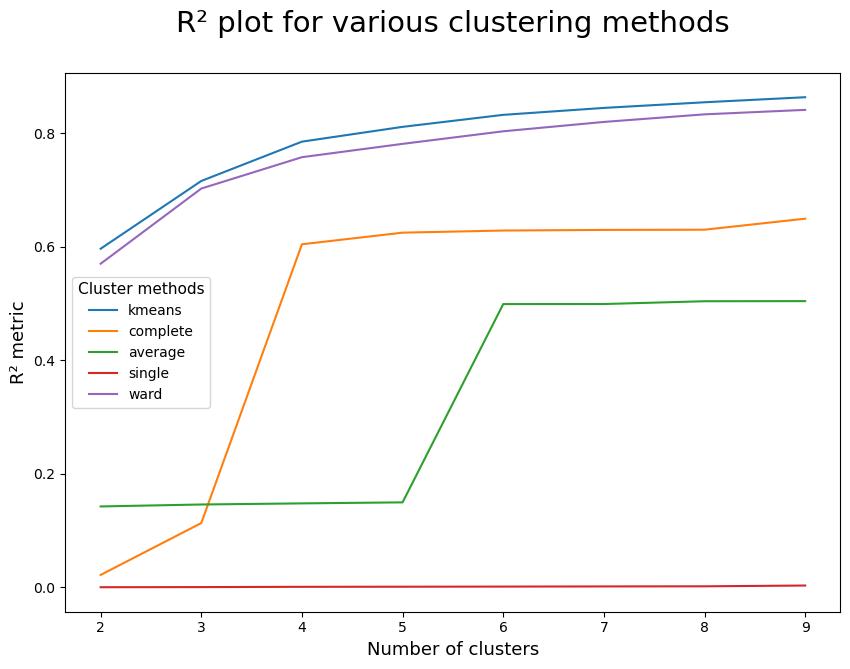

In [10]:
pd.DataFrame(r2_scores).plot.line(figsize=(10,7))

plt.title("R² plot for various clustering methods\n", fontsize=21)
plt.legend(title="Cluster methods", title_fontsize=11)
plt.xlabel("Number of clusters", fontsize=13)
plt.ylabel("R² metric", fontsize=13)
plt.show()

A dendrogram is a tree-like diagram that is used to illustrate the arrangement of clusters created by hierarchical clustering. It represents how data points (or clusters) are merged step-by-step in the hierarchical clustering process. Dendrograms are useful for the following purposes:

- **Visualizing Cluster Relationships**: It shows how clusters are formed and how closely they are related to one another.
- **Determining the Optimal Number of Clusters**: By cutting the dendrogram at a specific height, it is possible to identify the ideal number of clusters. The height reflects the threshold of similarity or distance.

A dendrogram shows how clusters are merged at each step. By cutting the dendrogram at a specific height, we can define the number of clusters. <br>
Analyzing this dendrogram, we can see a clear separation with 3 clusters, making them potential candidates for the optimal number of clusters.

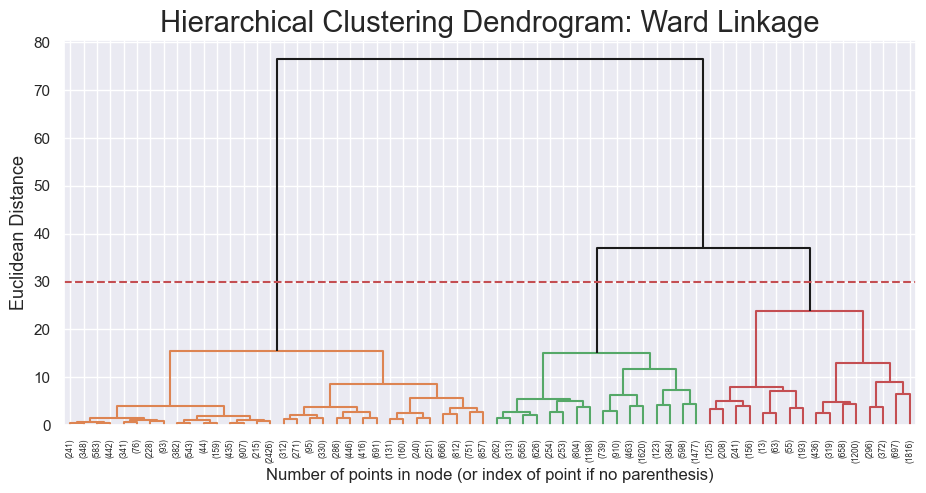

In [11]:
linkage = 'ward'
distance = 'euclidean'

hclust = AgglomerativeClustering(linkage=linkage, metric=distance, distance_threshold=0, n_clusters=None)
hc_labels = hclust.fit_predict(df_behaviour)

counts = np.zeros(hclust.children_.shape[0])
n_samples = len(hclust.labels_)

for i, merge in enumerate(hclust.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1 
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack(
    [hclust.children_, hclust.distances_, counts]
).astype(float)

sns.set()
fig = plt.figure(figsize=(11,5))
y_threshold = 30
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
plt.hlines(y_threshold, 0, 1000, colors="r", linestyles="dashed")
plt.title(f'Hierarchical Clustering Dendrogram: {linkage.title()} Linkage', fontsize=21)
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel(f'{distance.title()} Distance', fontsize=13)
plt.show()

### 3.1.2. Hierarchical Clustering - Silhouette Score 

The **silhouette score** helps us assess how well the data points fit into their assigned clusters. It looks at two things: 

- **Cohesion**: How close points are to others in the same cluster.
- **Separation**: How far points are from clusters that are different.

A **higher silhouette score** (closer to 1) means that the clusters are well-defined, with points tightly grouped together and clearly separated from other clusters. A **lower score** (close to 0) suggests that the clusters may overlap, while a **negative score** indicates points might have been placed in the wrong cluster.

By looking at the silhouette score for different numbers of clusters, we can pick the number of clusters that gives the **best score** that can be seen by the higher silhouete score. The goal is to have the less negatives possible, because positives mean that each point correctly belongs to the cluster that it was assigned to.

For hierarchical clustering, the highest silhouette score was observed with 2 clusters, indicating it is the best choice in this case.

In [12]:
# Compute silhouette score for different n_clusters
for n_clusters in [2, 3, 4]:
    hc_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=n_clusters)
    labels = hc_clust.fit_predict(df_behaviour)
    silhouette_avg = silhouette_score(df_behaviour, labels)
    print(f"Silhouette Score for {n_clusters} clusters: {silhouette_avg}")

Silhouette Score for 2 clusters: 0.5022759253853577
Silhouette Score for 3 clusters: 0.4300684027001168
Silhouette Score for 4 clusters: 0.42692724103222823


### 3.1.4. Hierarchical Clustering - Final Solution

After the analysis of the sillouete score we conclude that the optimal amount of clusters is either 2 or 3. As the results for this clustering seem to be good, we will assess both the options along with the other clusterings.

In [13]:
# solution with 2 clusters

hc2_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=2)
hc2_labels = hc2_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc2_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

,0,1,2,3,4,5,6
hierarc_labels,,,,,,,
0,0.108731,0.108838,0.647138,0.112670,0.116709,0.180207,0.088642
1,0.039982,0.020005,0.077914,0.031735,0.033690,0.036055,0.023912


In [14]:
r2 = get_r2(df_behaviour, hc2_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, hc2_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["HC_2"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)

R² Score: 0.5703015669646841
Silhouette Score: 0.5022759253853577


C:\Users\joaom\AppData\Local\Temp\ipykernel_53468\510658641.py:8: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)


In [15]:
# solution with 3 clusters

hc3_clust = AgglomerativeClustering(linkage='ward', metric='euclidean', n_clusters=3)
hc3_labels = hc3_clust.fit_predict(df_behaviour)

df_concat = pd.concat([df_behaviour, pd.Series(hc3_labels, name='hierarc_labels', index=df_behaviour.index)], axis=1)
df_concat.groupby('hierarc_labels').mean()

,0,1,2,3,4,5,6
hierarc_labels,,,,,,,
0,0.159459,0.178098,0.835488,0.177251,0.178938,0.263395,0.139558
1,0.039982,0.020005,0.077914,0.031735,0.033690,0.036055,0.023912
2,0.075925,0.064048,0.525330,0.070905,0.076465,0.126409,0.055714


In [16]:
r2 = get_r2(df_behaviour, hc3_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, hc3_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["HC_3"])

results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)

R² Score: 0.7027530223205135
Silhouette Score: 0.4300684027001168


<a class="anchor" id="kmeans">

## 3.2. K-Means Algorithm
</a>


### 3.2.1.K- Means - Inertia ( Defining the number of cluster)

Inertia measures how well data points fit into clusters by summing the squared distances between points and their nearest cluster centroid (**SSW**). 

- **Lower inertia**: Clusters are more compact, it's better because it means the datapoints are similar to each other.
- **Higher inertia**: Clusters are less defined.

Using the **elbow method**, we plot inertia for 1 to 10 clusters and look for the "elbow"—the point where inertia stops decreasing significantly. This indicates the optimal number of clusters.

Observing the following Inertia plot. We conclude that the optimal number of clusters is 2 or 3. We will investigate this further with other methods.

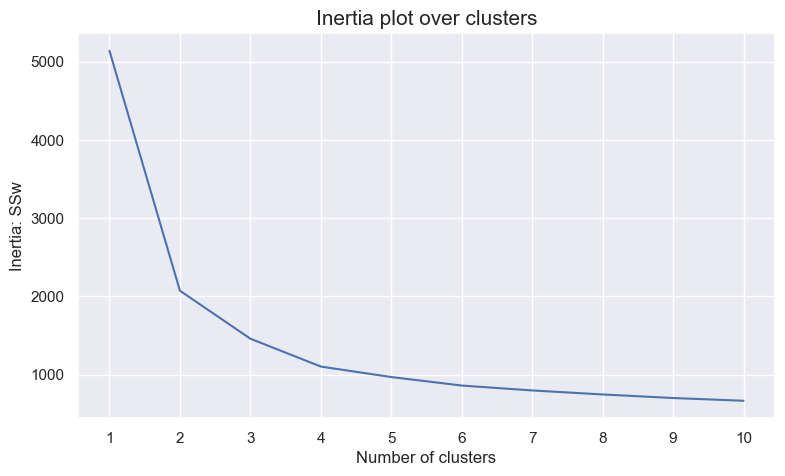

In [17]:
range_clusters = range(1, 11)    # test between 1 and 10 clusters
inertia = []
for n_clus in range_clusters:  # iterate over desired ncluster range
    kmclust = KMeans(n_clusters=n_clus, init='k-means++', n_init=15, random_state=1)
    kmclust.fit(df_behaviour)
    inertia.append(kmclust.inertia_)  # save the inertia of the given cluster solution

fig, ax = plt.subplots(figsize=(9,5))

ax.plot(range_clusters, inertia)
ax.set_xticks(range_clusters)
ax.set_ylabel("Inertia: SSw")
ax.set_xlabel("Number of clusters")
ax.set_title("Inertia plot over clusters", size=15)

plt.show()

### 3.2.2. K- Means - Silhouete Score (Defining the number of clusters)

As we saw previously, the silhouette score define how-well separated the clusters are, indicating with a higher score the better clusters. By computing silhouette scores for different numbers of clusters, we can determine the best number of clusters. <br>

The highest silhouette coeficient was obtained with 2 clusters, as it's possible to see.

For n_clusters = 2, the average silhouette_score is : 0.525292458908533
For n_clusters = 3, the average silhouette_score is : 0.47657900074611115
For n_clusters = 4, the average silhouette_score is : 0.43304919351291005
For n_clusters = 5, the average silhouette_score is : 0.37892678138916114
For n_clusters = 6, the average silhouette_score is : 0.3695874547012305
For n_clusters = 7, the average silhouette_score is : 0.3725402346308303


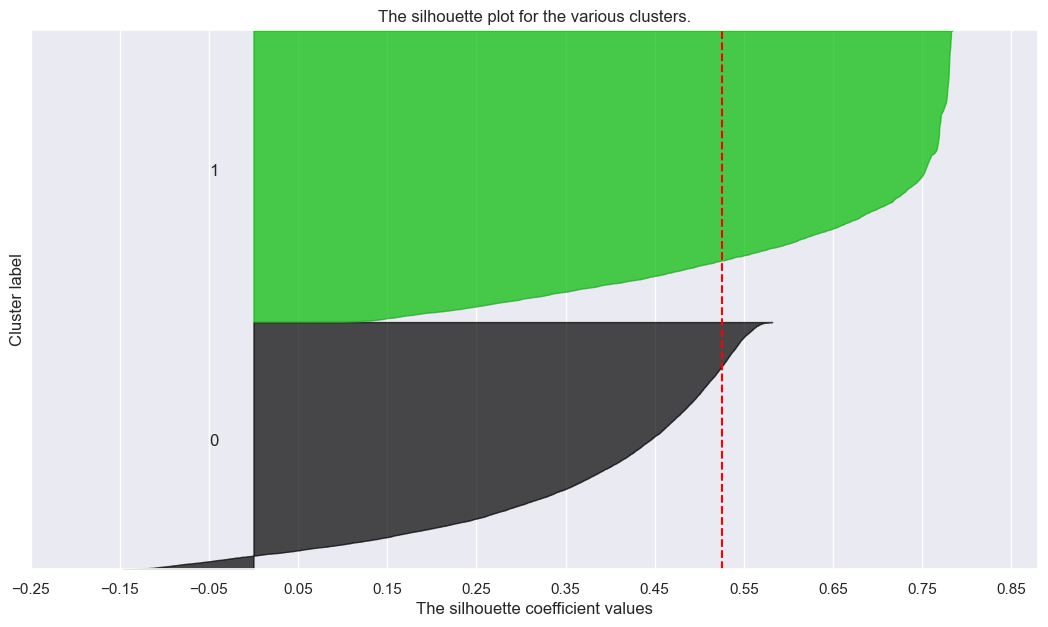

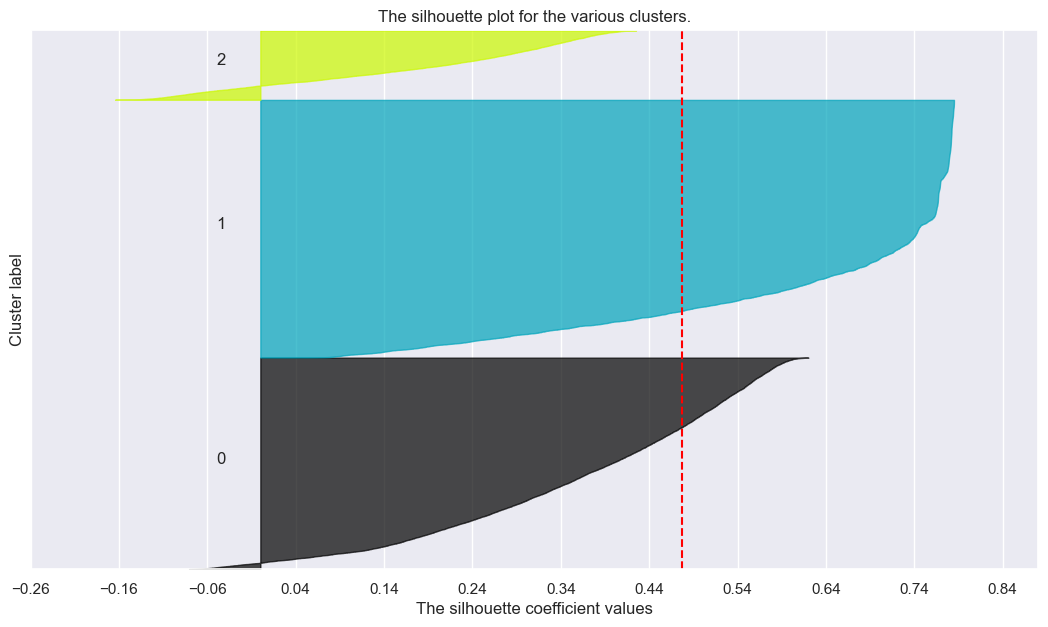

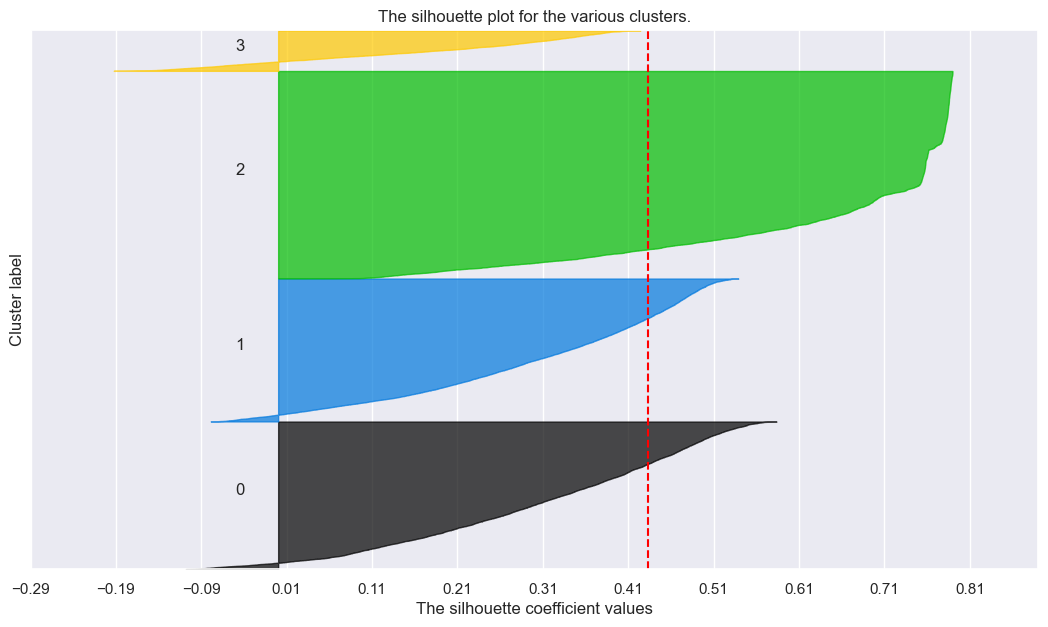

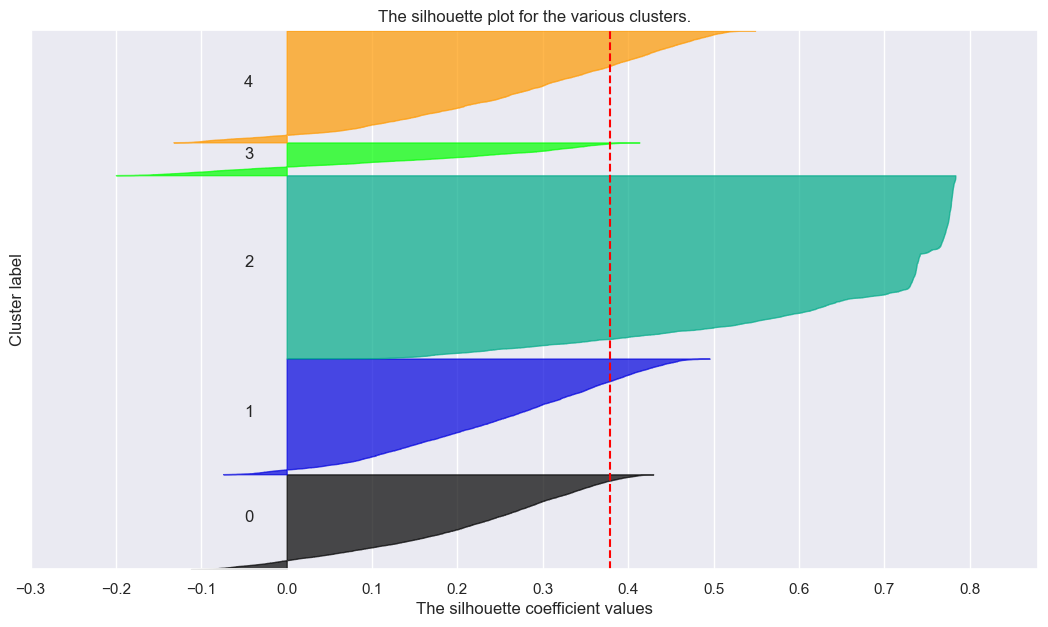

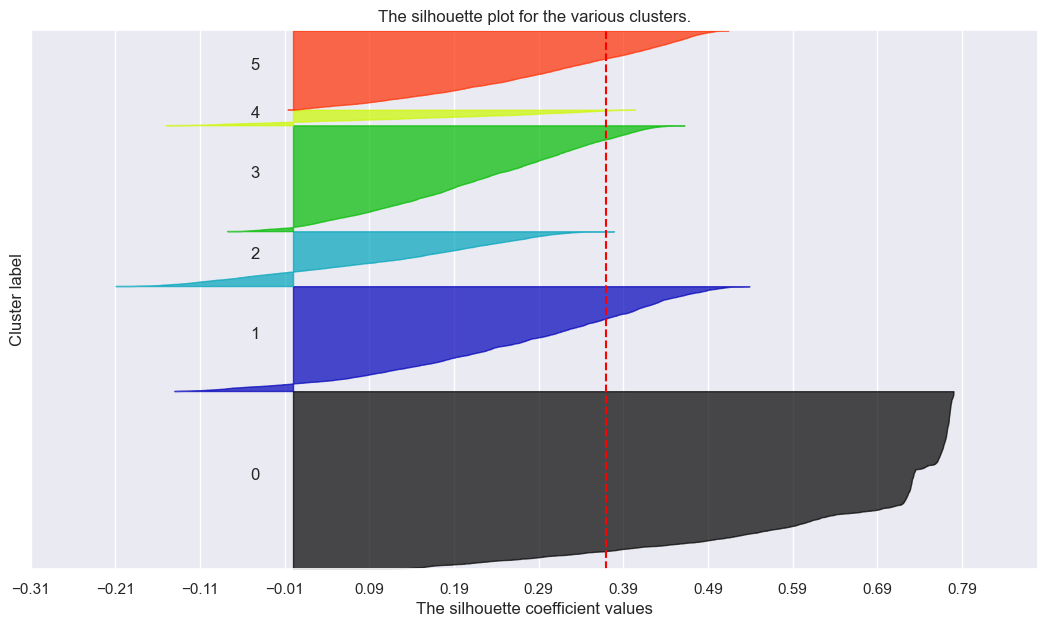

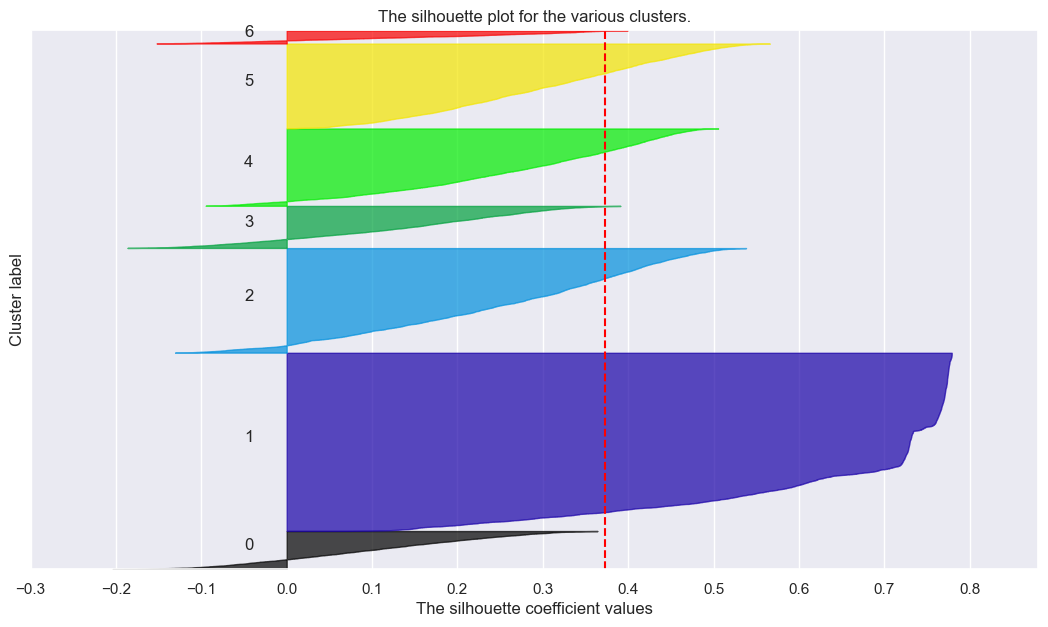

In [18]:
avg_silhouette = []
for nclus in range(2, 8):  # Loop from 2 to 7 clusters
    fig = plt.figure(figsize=(13, 7))
    
    kmclust = KMeans(n_clusters=nclus, init='k-means++', n_init=15, random_state=1)
    cluster_labels = kmclust.fit_predict(df_behaviour)

    silhouette_avg = silhouette_score(df_behaviour, cluster_labels)
    avg_silhouette.append(silhouette_avg)
    print(f"For n_clusters = {nclus}, the average silhouette_score is : {silhouette_avg}")

    sample_silhouette_values = silhouette_samples(df_behaviour, cluster_labels)

    y_lower = 10
    for i in range(nclus):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.nipy_spectral(float(i) / nclus)
        plt.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10  

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    plt.axvline(x=silhouette_avg, color="red", linestyle="--")
    
    xmin, xmax = np.round(sample_silhouette_values.min() - 0.1, 2), np.round(sample_silhouette_values.max() + 0.1, 2)
    plt.xlim([xmin, xmax])
    
    plt.ylim([0, len(df_behaviour) + (nclus + 1) * 10])

    plt.yticks([])  
    plt.xticks(np.arange(xmin, xmax, 0.1))

plt.show()


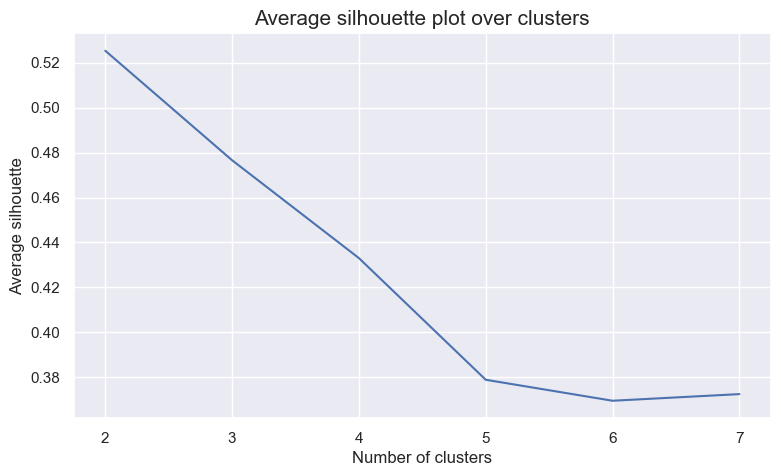

In [19]:
plt.figure(figsize=(9, 5))
plt.plot(range(2, 8), avg_silhouette)
plt.ylabel("Average silhouette")
plt.xlabel("Number of clusters")
plt.title("Average silhouette plot over clusters", size=15)
plt.xticks(range(2, 8)) 
plt.show()

### 3.2.3. K-Means Optimal clusters
After the analysis of the sillouete score and the inertia plot we conclude that the optimal amount of clusters is either 2 or 3. As the results for this clustering seem to be very good, we will assess both the options along with the other clusterings.
#### 2 clusters

In [20]:
kmclust = KMeans(n_clusters=2, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_behaviour)

df_concat = pd.concat((df_behaviour, pd.Series(km_labels, name='labels', index=df_behaviour.index)), axis=1)
df_concat.groupby('labels').mean()

,0,1,2,3,4,5,6
labels,,,,,,,
0,0.117897,0.120913,0.704898,0.123569,0.127807,0.194486,0.097361
1,0.043997,0.024997,0.126525,0.036369,0.038513,0.048661,0.027616


In [21]:
r2 = get_r2(df_behaviour, km_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, km_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["KMeans_2"])

# Add the new row to the DataFrame using pd.concat
results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)
# results_df

R² Score: 0.596682811917527
Silhouette Score: 0.525292458908533


#### 3 clusters

In [22]:
kmclust = KMeans(n_clusters=3, init='k-means++', n_init=15, random_state=1)
km_labels = kmclust.fit_predict(df_behaviour)


df_concat = pd.concat((df_behaviour, pd.Series(km_labels, name='labels', index=df_behaviour.index)), axis=1)
df_concat.groupby('labels').mean()

,0,1,2,3,4,5,6
labels,,,,,,,
0,0.078234,0.067464,0.609334,0.075425,0.080160,0.131151,0.057926
1,0.041807,0.022226,0.091704,0.033826,0.035670,0.042230,0.025512
2,0.211029,0.247534,0.843953,0.237408,0.240224,0.340541,0.191507


In [23]:
r2 = get_r2(df_behaviour, km_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, km_labels)
print(f"Silhouette Score: {silhouete}")

new_row = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["KMeans_3"])

# Add the new row to the DataFrame using pd.concat
results_df = pd.concat([results_df, new_row], axis=0, ignore_index=False)
# results_df

R² Score: 0.7161205095318504
Silhouette Score: 0.47657900074611115


<a class="anchor" id="som">
    
## 3.3. SOM
</a>


In [8]:
df_behaviour_noscale

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek,diversification
0,28.88,5,1,2,0,1
1,19.21,2,1,2,0,2
2,9.20,2,1,2,0,1
3,31.56,3,2,1,1,2
4,55.44,5,2,1,1,2
...,...,...,...,...,...,...
31883,18.04,1,0,1,0,1
31884,18.04,1,0,1,0,1
31885,17.79,1,0,1,0,1
31886,12.03,1,0,1,0,1


In [9]:
data_som = df_behaviour.copy()

In [11]:
data_som.columns = ['monetary', 'product_count', 'days_as_customer', 'DOW_weekends',
                    'DOW_daysweek', 'diversification']
data_som

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek,diversification
0,0.051925,0.049383,0.011111,0.105263,0.000000,0.000000
1,0.034313,0.012346,0.011111,0.105263,0.000000,0.090909
2,0.016082,0.012346,0.011111,0.105263,0.000000,0.000000
3,0.056806,0.024691,0.022222,0.052632,0.022727,0.090909
4,0.100299,0.049383,0.022222,0.052632,0.022727,0.090909
...,...,...,...,...,...,...
31660,0.032182,0.000000,0.000000,0.052632,0.000000,0.000000
31661,0.032182,0.000000,0.000000,0.052632,0.000000,0.000000
31662,0.031727,0.000000,0.000000,0.052632,0.000000,0.000000
31663,0.021236,0.000000,0.000000,0.052632,0.000000,0.000000


In [12]:
num_data_points = data_som.shape[0]
print("Nr. of data points:" , num_data_points)

print("Mapsize:" , 5*(num_data_points)**(1/2)) # from an university study

Nr. of data points: 31665
Mapsize: 889.7331060492241


In [13]:
import itertools
import numpy as np
import pandas as pd
from minisom import MiniSom

# Convert DataFrame to NumPy array
data_array = data_som.to_numpy()

# Function to calculate topographic error
def calculate_topographic_error(som, data):
    errors = 0
    for sample in data:
        bmu_1 = som.winner(sample)
        distances = np.linalg.norm(som._weights - sample, axis=-1)
        bmu_2 = np.unravel_index(np.argsort(distances.ravel())[1], distances.shape)
        neighbors = som.get_neighbors(bmu_1)
        if bmu_2 not in neighbors:
            errors += 1
    return errors / len(data)

# Grid search function
def grid_search_som(data, param_grid):
    results = []
    for params in itertools.product(*param_grid.values()):
        grid_size, sigma, learning_rate, iterations = params
        som = MiniSom(
            x=grid_size[0], y=grid_size[1],
            input_len=data.shape[1],
            sigma=sigma, learning_rate=learning_rate,
            random_seed=42, neighborhood_function='gaussian'
        )
        som.random_weights_init(data)
        som.train(data, iterations)

        qe = som.quantization_error(data)
        te = calculate_topographic_error(som, data)

        results.append({
            'Grid Size': grid_size,
            'Sigma': sigma,
            'Learning Rate': learning_rate,
            'Iterations': iterations,
            'Quantization Error': qe,
            'Topographic Error': te
        })

    return pd.DataFrame(results)

# Define custom neighbor function for hexagonal grids
def get_neighbors_hexagonal(som, node):
    x, y = node
    neighbors = []
    for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1), (-1, -1), (1, 1)]:
        nx, ny = x + dx, y + dy
        if 0 <= nx < som._weights.shape[0] and 0 <= ny < som._weights.shape[1]:
            neighbors.append((nx, ny))
    return neighbors

MiniSom.get_neighbors = get_neighbors_hexagonal

In [108]:
# Define parameter grid
param_grid = {
    'grid_size': [(30, 30)], 
    'sigma': [0.5, 1.0, 1.5, 2.0, 2.5, 3.0],
    'learning_rate': [0.1, 0.5, 1.0, 1.5, 2.0],
    'iterations': [500, 1000]
}

# Perform grid search
results_df = grid_search_som(data_array, param_grid)


results_df['Combined Score'] = results_df['Quantization Error'] + results_df['Topographic Error']
best_row_idx = results_df['Combined Score'].idxmin()
best_params = results_df.loc[best_row_idx]
print("Best Parameters:")
print(best_params)

c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:631: RuntimeWarning: invalid value encountered in sqrt
  return sqrt(-2 * cross_term + input_data_sq + weights_flat_sq.T)


KeyboardInterrupt: 

In [88]:
results_df.sort_values(by='Combined Score', ascending=True).head(5)

,Grid Size,Sigma,Learning Rate,Iterations,Quantization Error,Topographic Error,Combined Score
54,"(30, 30)",3.0,1.0,500,0.117617,0.240424,0.358041
46,"(30, 30)",2.5,1.5,500,0.112709,0.294575,0.407284
56,"(30, 30)",3.0,1.5,500,0.118522,0.306215,0.424737
55,"(30, 30)",3.0,1.0,1000,0.108370,0.334082,0.442452
53,"(30, 30)",3.0,0.5,1000,0.108081,0.350182,0.458263


In [15]:
from minisom import MiniSom
import numpy as np

best_grid_size = (30, 30)
best_sigma = 3.0
best_learning_rate = 1.0
best_iterations = 500

som = MiniSom(
    x=best_grid_size[0], 
    y=best_grid_size[1], 
    input_len=data_array.shape[1],
    sigma=best_sigma, 
    learning_rate=best_learning_rate,
    neighborhood_function='gaussian',
    random_seed=42
)

# Optionally: PCA-based weight initialization
som.pca_weights_init(data_array)

print("PCA weights init")
print("Before training:")
qe_before = np.round(som.quantization_error(data_array), 5)
te_before = np.round(calculate_topographic_error(som, data_array), 5)
print(f"QE: {qe_before}, TE: {te_before}")

# Train the SOM
som.train(data_array, best_iterations)

print("After training:")
qe_after = np.round(som.quantization_error(data_array), 5)
te_after = np.round(calculate_topographic_error(som, data_array), 5)
print(f"QE: {qe_after}, TE: {te_after}")


# som = MiniSom(
#     x=best_grid_size[0], 
#     y=best_grid_size[1], 
#     input_len=data_array.shape[1],
#     sigma=best_sigma, 
#     learning_rate=best_learning_rate,
#     neighborhood_function='gaussian',
#     random_seed=42
# )

# # Or random initialization
# som.random_weights_init(data_array)

# print("Random weights init")
# print("Before training:")
# qe_before = np.round(som.quantization_error(data_array), 5)
# te_before = np.round(calculate_topographic_error(som, data_array), 5)
# print(f"QE: {qe_before}, TE: {te_before}")

# # Train the SOM
# som.train(data_array, best_iterations)

# print("After training:")
# qe_after = np.round(som.quantization_error(data_array), 5)
# te_after = np.round(calculate_topographic_error(som, data_array), 5)
# print(f"QE: {qe_after}, TE: {te_after}")


c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\minisom.py:447: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


PCA weights init
Before training:
QE: 0.45769, TE: 1.0
After training:
QE: 0.09512, TE: 0.59261


QE and TE with random weights initialization was worse than with the PCA weights initialization

In [16]:
def convert_map_to_euclidean(i, j):
    x = i + 0.5 * (j % 2)  # Shift every other row by 0.5
    y = j * (np.sqrt(3) / 2)
    return x, y

def plot_hexagons(
    ax, 
    colornorm, 
    matrix_vals, 
    label="", 
    annot=False, 
    cmap=None
):
    """
    Plots the values in 'matrix_vals' using hexagonal cells.
    
    Parameters:
    -----------
    ax : matplotlib Axes
        The axes on which to draw the hexagons.
    colornorm : matplotlib.colors.Normalize
        Normalization object for mapping values to [0, 1].
    matrix_vals : 2D array
        Values to be visualized. shape = (M, N).
    label : str, optional
        Title label for the subplot.
    annot : bool, optional
        If True, numeric values are shown inside each hex.
    cmap : matplotlib.colors.Colormap or None, optional
        Colormap to use. Defaults to 'inferno' if None is provided.
    """
    # Default to 'inferno' if no cmap is specified
    if cmap is None:
        cmap = cm.inferno

    rows, cols = matrix_vals.shape
    for i in range(rows):
        for j in range(cols):
            x, y = convert_map_to_euclidean(i, j)
            value = matrix_vals[i, j]
            # Map the value to a color using the given colormap + normalization
            hex_color = cmap(colornorm(value))
            
            # Draw a regular hexagon
            hex_patch = RegularPolygon(
                (x, y),
                numVertices=6,
                radius=np.sqrt(1 / 3),
                facecolor=hex_color,
                alpha=1,
                edgecolor="white",
                linewidth=0.5
            )
            ax.add_patch(hex_patch)

            # Optionally annotate
            if annot:
                annot_val = int(np.round(value))
                ax.text(
                    x, y, annot_val,
                    ha="center",
                    va="center",
                    fontsize="x-small",
                )

    # Formatting
    ax.margins(0.05)
    ax.set_aspect("equal")
    ax.axis("off")
    ax.set_title(label)

    # Add color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    sm = cm.ScalarMappable(norm=colornorm, cmap=cmap)
    sm.set_array([])
    Colorbar(ax=cax, mappable=sm, orientation="vertical")


### Ploting the Plane Components using the trained SOM

Self-Organizing Map (SOM) component planes provide a visual representation of how individual features are distributed across the trained SOM grid. Each component plane corresponds to one feature in the input data and shows the value of that feature for every neuron (hexagon) in the SOM grid.

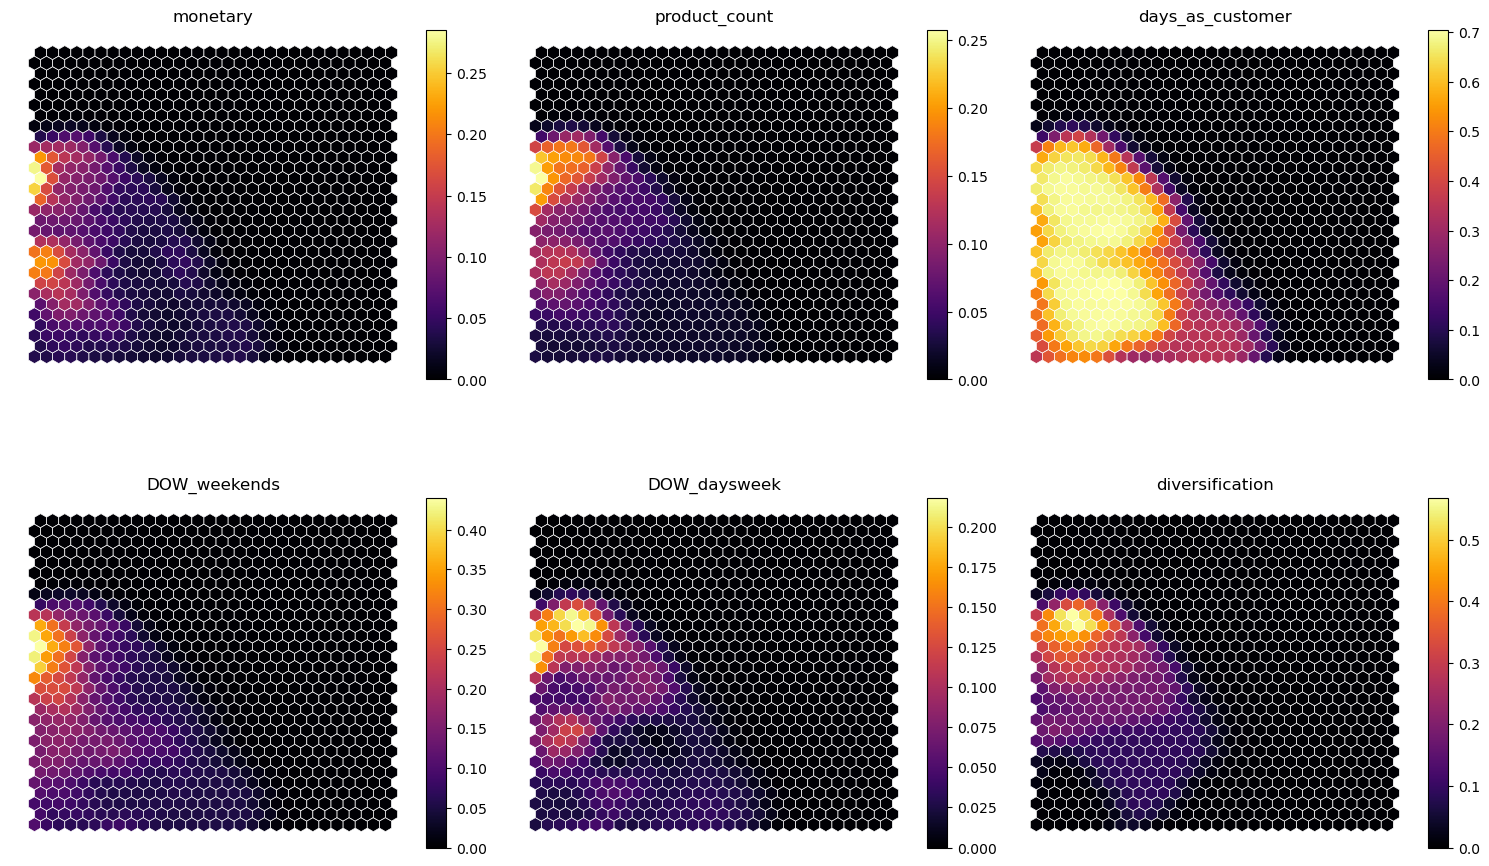

In [36]:
from matplotlib.colors import Normalize

weights = som.get_weights()  # shape (M, N, num_features)
num_features = weights.shape[2]
feature_names = data_som.columns  # Use the names of features from your dataset

# Define 5 rows and 3 columns for 15 subplots
rows, cols = 2, 3
fig, axes = plt.subplots(rows, cols, figsize=(15, 10))  # Adjust figsize for better visualization
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Plot the feature planes
for i in range(min(num_features, rows * cols)):
    plane = weights[:, :, i]  # MxN array for feature i
    ax = axes[i]

    colornorm = Normalize(vmin=plane.min(), vmax=plane.max())
    
    plot_hexagons(
        ax=ax, 
        colornorm=colornorm, 
        matrix_vals=plane, 
        label=feature_names[i],  # Use the feature name as the label
        annot=False
    )

# If there are fewer features than subplots, hide unused subplots
for j in range(min(num_features, rows * cols), rows * cols):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


- There is a consistent clustering of high activity toward certain regions of the SOM, indicating natural groupings of customer behavior.
- Different metrics exhibit overlapping but slightly distinct patterns, suggesting nuances in behavior among customer segments.
- Areas with low or no activity (black regions) might represent less common customer behaviors.
_____________________________________
- In the monetary component plane, the hexagons with higher intensity (representing higher spending) correspond to similar regions with higher values in the product_count component plane. Which confirms the correlation between spending more money and buying more products, as the same neurons (or customer groups) exhibit high values in both features. 

- In the DOW_weekends and DOW_daysweek component planes, the regions of higher activity for weekends and weekdays overlap with the regions of higher spending in the monetary plane. This indicates that high spenders make purchases both on weekends and weekdays, reflecting consistent purchasing behavior throughout the week.

Potential Actions:
- Target High-Value Clusters: Focus marketing efforts on the high-monetary and high-product-count clusters.
- Cross-Sell to Diverse Buyers: Engage customers with high diversification scores for cross-selling opportunities.

#### Ploting the U-Matrix using the trained SOM

In [131]:
# Suppose you have a trained SOM named 'som'
u_matrix = som.distance_map()  # shape (M, N)

In [142]:
M, N = som.get_weights().shape[:2]  # e.g., 10, 10
final_weights = som.get_weights().reshape(M*N, -1)  
# shape = (M*N, num_features)

# Clustering using KMeans
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(final_weights)
# 'labels' is a 1D array of length M*N, cluster ID of each neuron


c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


In [143]:
from collections import defaultdict

# Map clusters to SOM grid
cluster_coords = defaultdict(list)

for i in range(M):
    for j in range(N):
        neuron_index = i * N + j
        cluster_id = labels[neuron_index]
        cluster_coords[cluster_id].append((i, j))  # Store neuron grid positions

### U-Matrix using trained SOM

The U-Matrix (Unified Distance Matrix) is a visualization technique for Self-Organizing Maps that shows the distances between neighboring neurons in the SOM grid. It provides insights into the structure and topology of the data by highlighting the relationships between clusters.

It helps identifying natural groupings of the data within the SOM grid, highlighting the regions where the points are less similar, providing an intuitive overview of the underlying data structure.

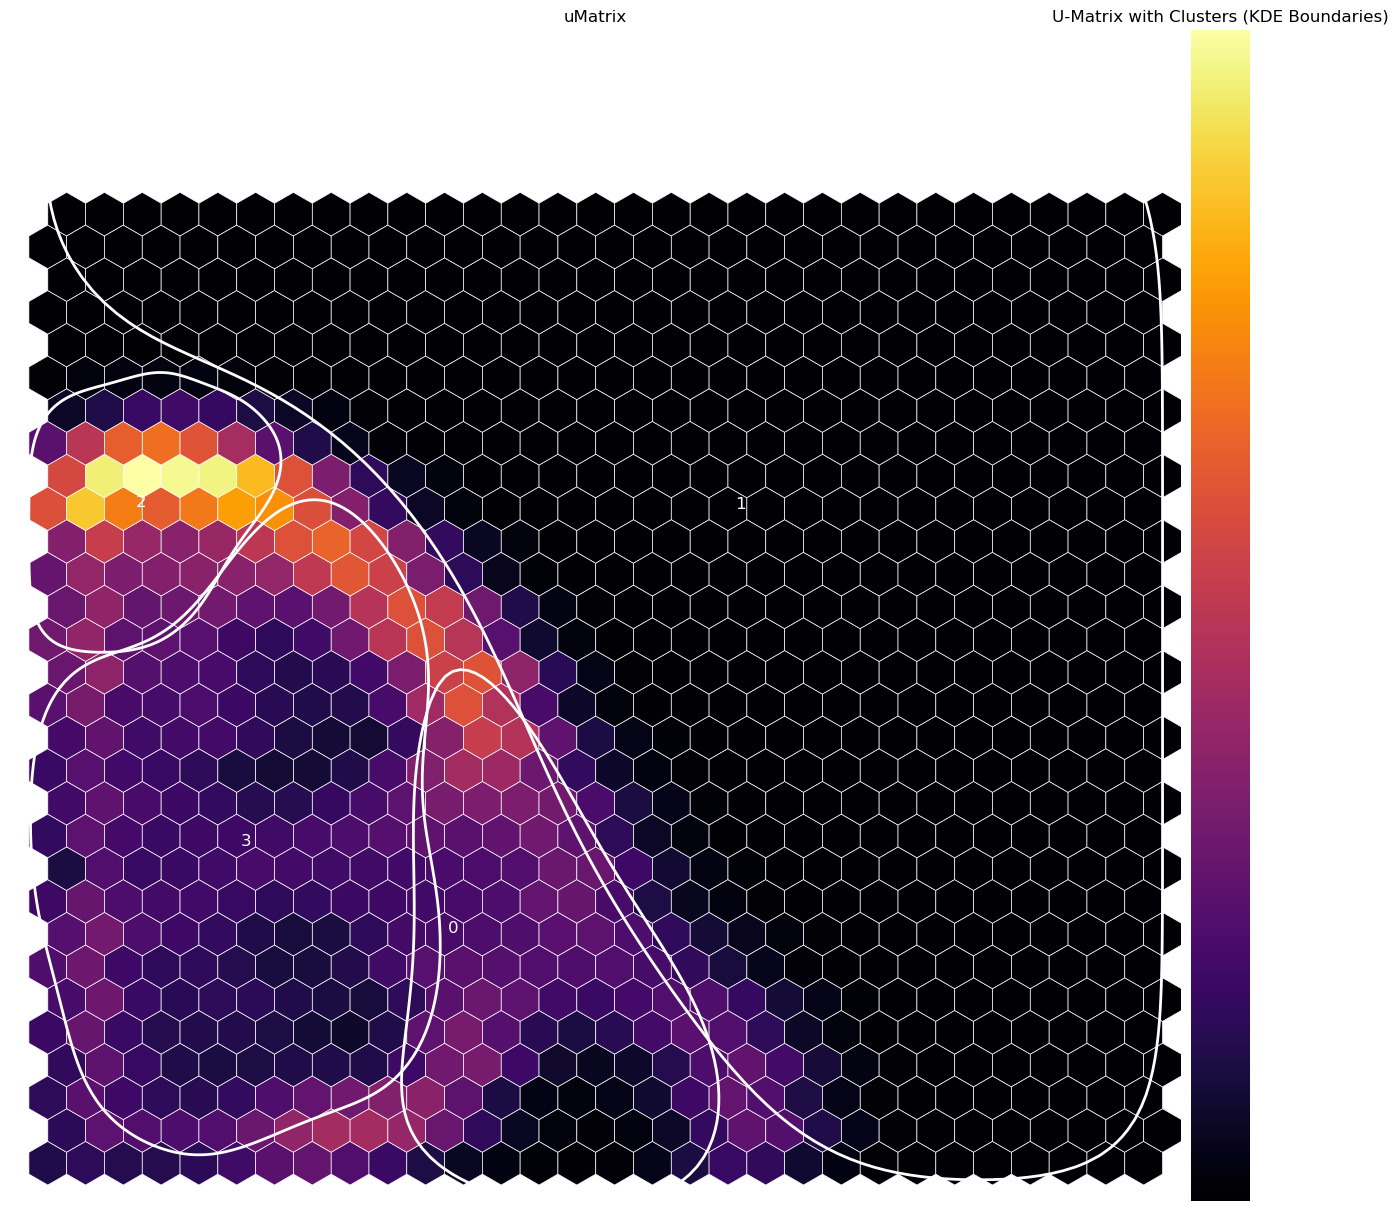

In [144]:
from scipy.stats import gaussian_kde

# Plot U-Matrix with plot_hexagons
fig, ax = plt.subplots(figsize=(16, 16))
colornorm = Normalize(vmin=u_matrix.min(), vmax=u_matrix.max())
plot_hexagons(ax, colornorm, u_matrix, label="uMatrix", annot=False)

# KDE and Contour for cluster boundaries
for cluster_id, coords in cluster_coords.items():
    if len(coords) < 3:  # Skip small clusters
        continue

    coords = np.array(coords)
    x, y = coords[:, 0], coords[:, 1]

    # Perform KDE for smooth boundaries
    kde = gaussian_kde(np.vstack([x, y]))
    x_grid, y_grid = np.meshgrid(
        np.linspace(x.min() - 1, x.max() + 1, 100),
        np.linspace(y.min() - 1, y.max() + 1, 100),
    )
    z = kde(np.vstack([x_grid.ravel(), y_grid.ravel()])).reshape(x_grid.shape)

    # Plot contour for this cluster
    ax.contour(x_grid, y_grid, z, levels=[z.max() * 0.5], colors='white', linewidths=2)

# Optionally annotate cluster IDs
for cluster_id, coords in cluster_coords.items():
    if coords:
        centroid_x = np.mean([x for x, _ in coords])
        centroid_y = np.mean([y for _, y in coords])
        ax.text(centroid_x, centroid_y, str(cluster_id), color='white', fontsize=12, ha='center')

# Finalize and display plot
plt.title("U-Matrix with Clusters (KDE Boundaries)")
plt.axis('off')
plt.show()


The U-Matrix clearly shows regions of low distances (darker areas), which correspond to cohesive clusters of similar data points.

The high-distance regions (lighter areas) form natural boundaries, separating these clusters.

##### There are at least four main clusters visible in the U-Matrix:

1. Diagonal/Elongated Cluster (Cluster 0):
- A stretched and irregularly shaped cluster extending diagonally from the center toward the bottom.
- This cluster exhibits moderate cohesion but spans a larger area, indicating potential internal heterogeneity.
- It is surrounded by clear boundaries, especially at its intersection with other clusters.

2. All-Black Cluster (Cluster 1):
- The all-black region suggests that the data points mapped to these neurons are very similar across all features.
- This could mean that this cluster corresponds to a large, well-defined, and homogeneous group in our dataset.

3. Top-Left Cluster (Cluster 2):
- A compact and well-defined cluster located in the top-left corner of the map.
- Surrounded by high U-Matrix distances, which form clear boundaries with neighboring clusters.
- Likely represents a distinct group of data points with high internal similarity and little overlap with others.


4. Bottom-Left Cluster (Cluster 3):
- A large, cohesive cluster with low distances, occupying much of the bottom-left region.
- This cluster is compact and internally consistent, likely representing a highly similar group of data points.


##### Boundaries Between Clusters:
- The yellow/orange regions highlight significant boundaries between clusters. These boundaries suggest areas where the data points mapped to neighboring neurons are dissimilar.
- Between the top-left cluster and the diagonal cluster, there is a sharp boundary with high U-Matrix values.
- Between the bottom-left cluster and the elongated diagonal cluster, the transitions are less sharp, indicating a gradual difference.

### Hits Map


A hit-map in the context of Self-Organizing Maps (SOMs) is a visualization tool used to evaluate the mapping of input data to the SOM's grid of neurons. It shows the number of data points (or samples) assigned to each neuron, providing insights into the density and distribution of the data across the SOM.

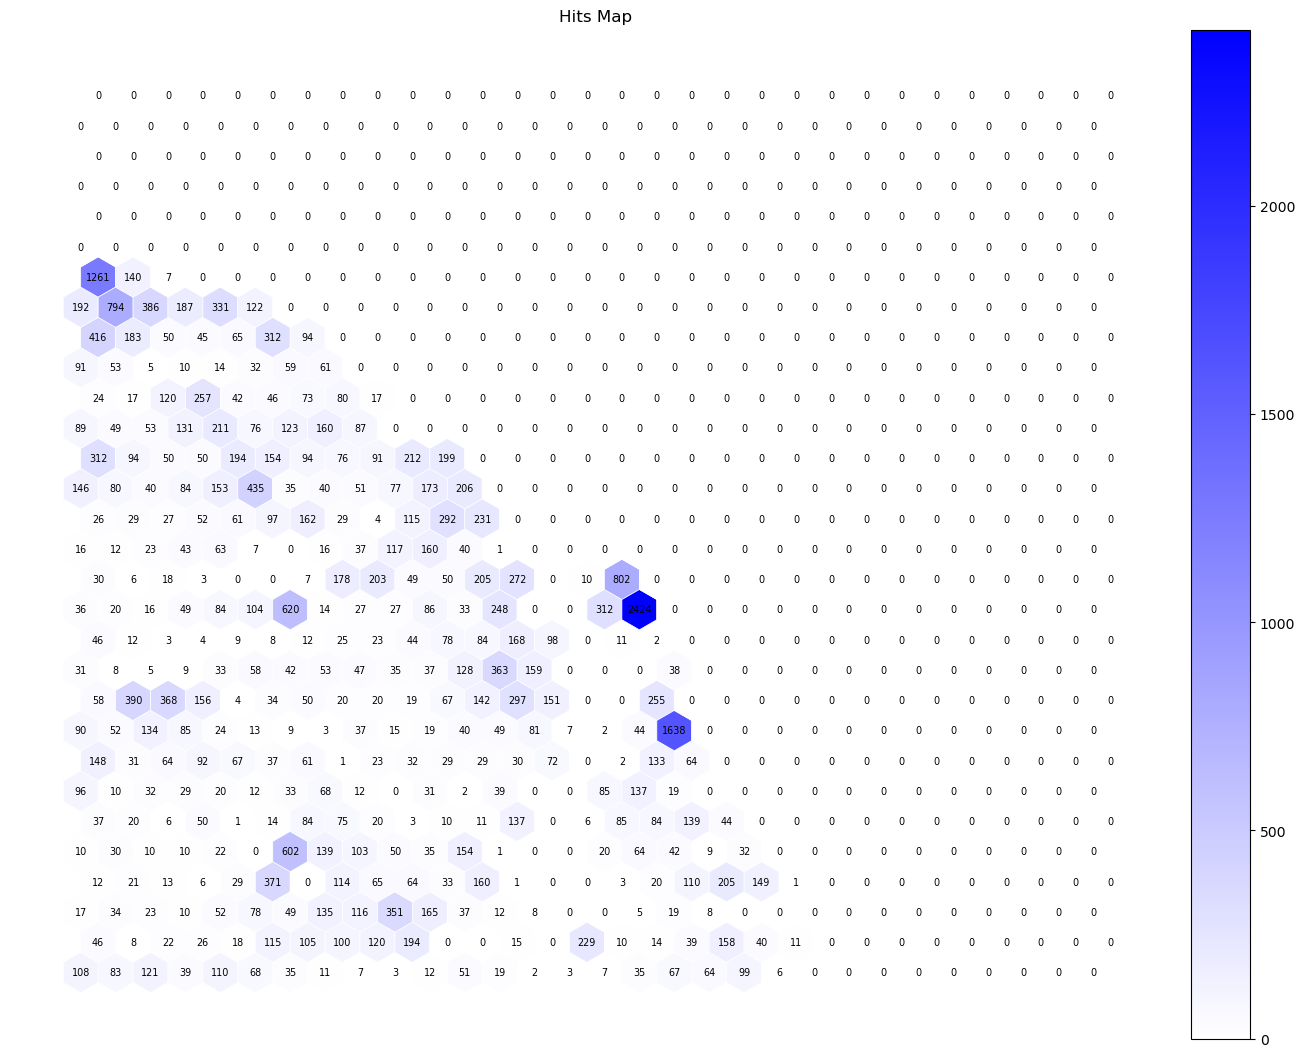

In [41]:
from matplotlib.colors import Normalize, LinearSegmentedColormap

def plot_hits_map_hex(som, data, title="Hits Map"):
    """
    1) Compute the hits map for 'data' given a trained 'som'.
    2) Plot it in hex form with a white→blue colormap.
    """
    # A) Compute hits per neuron
    M, N = som.get_weights().shape[:2]
    hits_map = np.zeros((M, N))
    
    # For each sample, find BMU and increment counter
    for sample in data:
        i, j = som.winner(sample)
        hits_map[i, j] += 1
    
    # B) Create a custom white→blue colormap
    white2blue = LinearSegmentedColormap.from_list(
        'white2blue', ['white', 'blue'], N=256
    )
    
    # C) Normalize from 0 up to the max number of hits
    colornorm = Normalize(vmin=0, vmax=hits_map.max())
    
    # D) Plot with the hex function
    fig, ax = plt.subplots(figsize=(16, 16))
    plot_hexagons(
        ax=ax,
        colornorm=colornorm,
        matrix_vals=hits_map,
        label=title,
        annot=True,            # Show numeric hit counts
        cmap=white2blue        # Use our custom white→blue colormap
    )
    plt.show()

plot_hits_map_hex(som, data_array)

1. High-Density Regions:
- The neurons in the center which appear to have more than 2000 hits and the neurons in the top-left region  have a very high number of hits compared to the rest of the map.
- This indicates a concentrated cluster of data points, meaning many similar data samples are grouped in this area.

2. Medium-Density Regions:
- The neurons in the center-bottom-left region show moderate hit values.
- These regions represent another significant cluster of data points, though less dense than the top-left.

3. Sparse Regions:
- The neurons in the middle to right-side areas of the map have very few or no hits (zeros).
- These areas indicate underutilized neurons or regions that represent no data points from the input set.

### Clustering the neuron weight vectors

#### Flatten the SOM Weights


In [42]:
weights_3d = som.get_weights()         # shape: (M, N, num_features)
M, N, num_features = weights_3d.shape

weights_2d = weights_3d.reshape(M * N, num_features)
# shape: (M*N, num_features)

#### Apply K-Means Clustering to the Flattened Weights

c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning:

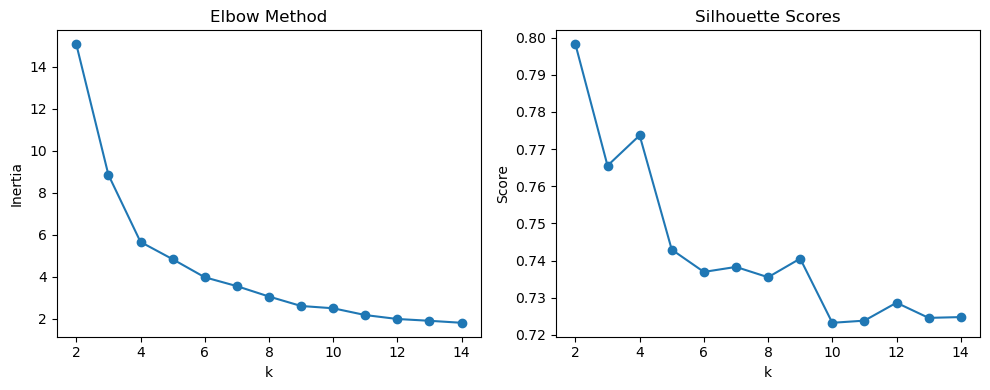

In [43]:
inertias = []
sil_scores = []
K_values = range(2, 15)  # Try k from 2 to 14

for k in K_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(weights_2d)
    
    # Inertia
    inertias.append(kmeans.inertia_)
    
    # Silhouette (requires more than 1 cluster)
    sil = silhouette_score(weights_2d, labels)
    sil_scores.append(sil)

# Plot elbow
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(K_values, inertias, 'o-')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

# Plot silhouette
plt.subplot(1,2,2)
plt.plot(K_values, sil_scores, 'o-')
plt.title("Silhouette Scores")
plt.xlabel("k")
plt.ylabel("Score")
plt.tight_layout()
plt.show()


### Visualizing the K-Means Clusters on the SOM

Using 4 as the number of clusters

In [145]:
weights_3d = som.get_weights()  # shape (M, N, num_features)
M, N, num_features = weights_3d.shape
weights_2d = weights_3d.reshape(M*N, num_features)

k = 4  # or 10
kmeans_behaviour = KMeans(n_clusters=k, random_state=42)
nodeclus_labels_behaviour = kmeans_behaviour.fit_predict(weights_2d)
# labels is a 1D array of length M*N, cluster ID for each neuron

cluster_map = labels.reshape(M, N)

c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


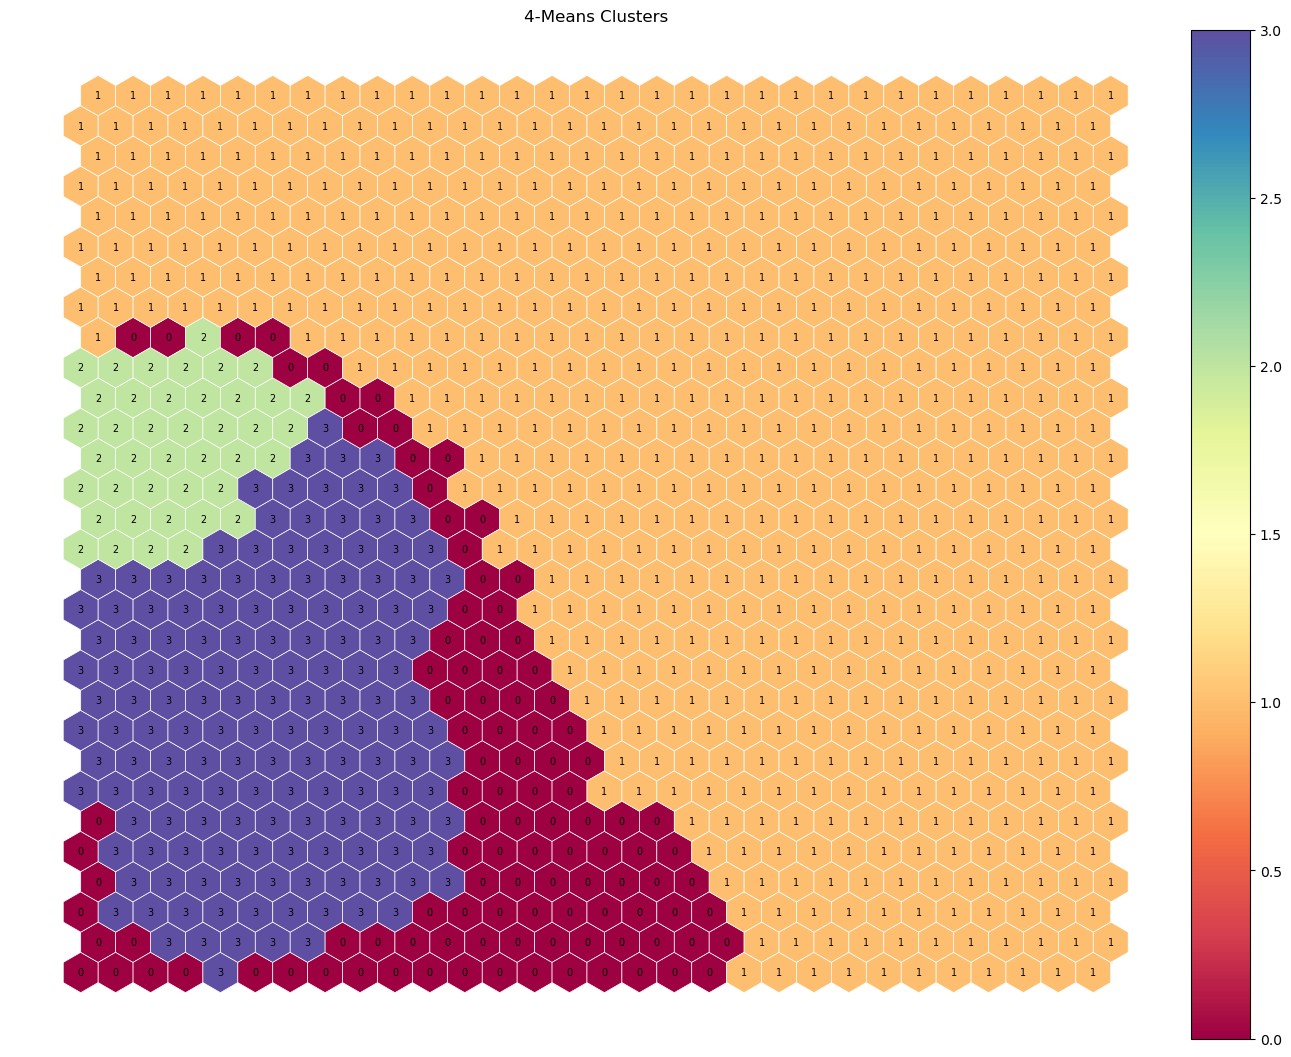

In [146]:
import matplotlib.colors as colors

fig, ax = plt.subplots(figsize=(16, 16))

# Create a discrete colormap for 'k' clusters:

norm = colors.Normalize(vmin=0, vmax=k-1)

plot_hexagons(
    ax=ax,
    colornorm=norm,
    matrix_vals=cluster_map,
    label=f"{k}-Means Clusters",
    annot=True,
    cmap=cm.Spectral
)

plt.show()


0. Cluster 0 (Red Region):
- Positioned primarily in the bottom-right corner, and it transitions into Cluster 3 (Blue).
- This cluster is moderately sized and distinct, representing another subgroup of neurons and likely data points.

1. Cluster 1 (Orange Region):
- This cluster dominates the upper and central regions of the SOM grid.
- It suggests a large group of neurons that share very similar characteristics, which likely corresponds to a highly homogeneous set of data points in the original dataset.
- The size and dominance of this cluster imply that the dataset contains many points with shared features that are generalized by this region.

2. Cluster 2 (Light Green Region):
- Found in the top-left corner of the SOM grid.
- This cluster is relatively small and compact, indicating a distinct group of data points with unique characteristics compared to the larger orange cluster (Cluster 1).
- This could represent an outlier group or a niche subgroup within the dataset.

3. Cluster 3 (Blue Region):
- Occupies a significant portion of the bottom-left corner of the SOM grid.
- This cluster is cohesive and distinct, suggesting another well-defined subgroup in the data.
- Its adjacency to Cluster 1 (Orange) indicates that some feature similarities exist, but it still forms a separate group.


In [148]:
from sklearn.metrics import calinski_harabasz_score

# After som is trained:
codebook_matrix = weights_3d.reshape(-1, weights_3d.shape[-1])

nodeclus_labels = kmeans_behaviour.fit_predict(codebook_matrix)


from sklearn.metrics import silhouette_score, davies_bouldin_score

sil_score = silhouette_score(codebook_matrix, nodeclus_labels, metric='euclidean')
dbi_score = davies_bouldin_score(codebook_matrix, nodeclus_labels)

print('Silhouette Score: %.3f' % sil_score)
print('Davies-Bouldin Index: %.3f' % dbi_score)
ch_score = calinski_harabasz_score(codebook_matrix, nodeclus_labels)
print('Calinski-Harabasz Index: %.3f' % ch_score)



Silhouette Score: 0.774
Davies-Bouldin Index: 0.712
Calinski-Harabasz Index: 3986.492


c:\Users\joaom\anaconda3\envs\DM2425\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


1. The Silhouette Score ranges from -1 to 1, where:
- 1 indicates perfect clustering with well-separated clusters and compact groups.
- 0 indicates overlapping or poorly separated clusters.
- Negative values indicate incorrect clustering where points are closer to other clusters than their own.
- A score of 0.774 suggests well-defined clusters with good separation and cohesion.

2. The Davies-Bouldin Index measures cluster compactness and separation. 
- Lower values are better, indicating smaller intra-cluster distances and larger inter-cluster distances.
- Values typically range from 0 (ideal) to ∞, with lower values being preferred.
- A value of 0.712 indicates good clustering quality, with relatively compact clusters and clear separation.

3. The Calinski-Harabasz Index evaluates the ratio of between-cluster dispersion to within-cluster dispersion. Higher values indicate better-defined clusters.
- There is no absolute range, as the value depends on the data and the number of clusters.
- A value of 3986.492 is relatively high, indicating that the clusters are well-formed with clear boundaries and low dispersion within clusters.

Dendogram

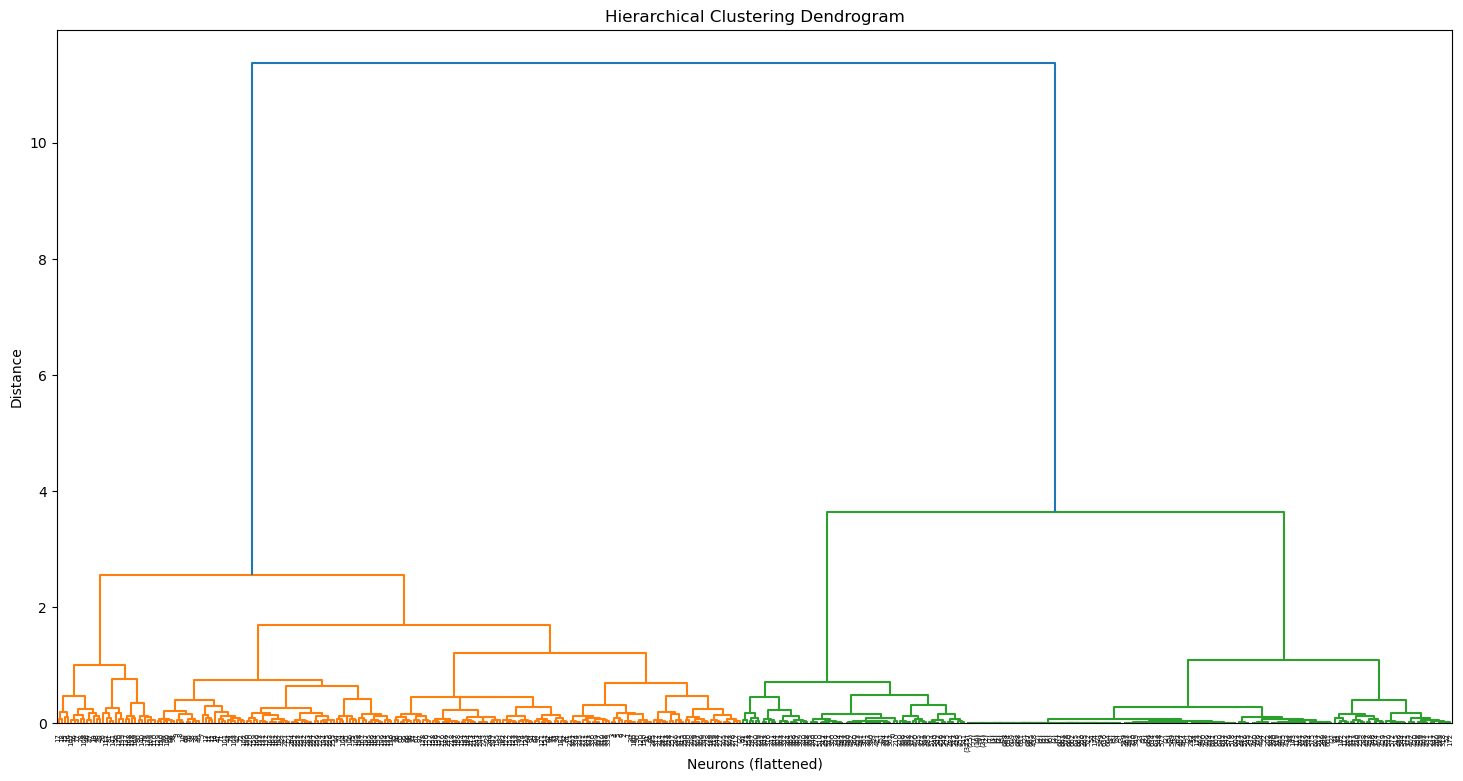

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# 1) Compute the linkage matrix (Ward's method, Euclidean distance)
linkage_matrix = linkage(weights_2d, method='ward', metric='euclidean')

# 2) Plot the dendrogram
plt.figure(figsize=(18, 9))
dendrogram(
    linkage_matrix,
    truncate_mode='level',  # or 'lastp'
    p=10                    # show only the last 10 merges
)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Neurons (flattened)")
plt.ylabel("Distance")
plt.show()


#### Flattened Weights + DataFrame

In [48]:
nodes_behaviour = weights_2d

In [49]:
df_nodes_behaviour = pd.DataFrame(nodes_behaviour, columns=data_som.columns)
df_nodes_behaviour['label'] = nodeclus_labels_behaviour
df_nodes_behaviour

# df_nodes_behaviours = pd.DataFrame(nodes_behaviour, columns=df_behaviour.columns)
# df_nodes_behaviours['label'] = nodeclus_labels
# df_nodes_behaviours

,monetary,product_count,days_as_customer,DOW_weekends,DOW_daysweek,diversification,label
0,3.683422e-02,2.920881e-02,3.526899e-01,1.033916e-01,2.434330e-02,6.302157e-03,0
1,3.781384e-02,2.709457e-02,4.110108e-01,9.042206e-02,2.549787e-02,2.904969e-03,0
2,4.188767e-02,2.860722e-02,4.506967e-01,9.203721e-02,2.561290e-02,4.089329e-03,0
3,4.715858e-02,3.503458e-02,4.746039e-01,1.066996e-01,2.748444e-02,7.762327e-03,0
4,5.576751e-02,4.598901e-02,4.848196e-01,1.264787e-01,3.225274e-02,1.428852e-02,0
...,...,...,...,...,...,...,...
895,2.158447e-23,3.472951e-23,1.075491e-22,7.385201e-23,4.829675e-23,1.275539e-22,1
896,2.108923e-24,3.427718e-24,9.941431e-24,7.289111e-24,4.529864e-24,1.262782e-23,1
897,1.877707e-25,3.075648e-25,8.430277e-25,6.540978e-25,3.884051e-25,1.138291e-24,1
898,1.516580e-26,2.496857e-26,6.555062e-26,5.310696e-26,3.038889e-26,9.299189e-26,1


#### Hierarchical Labels for 4 Clusters and BMU Indices per Data Row

In [50]:
n_clusters = 4
hier_labels = fcluster(linkage_matrix, n_clusters, criterion='maxclust')  # shape (M*N,)

# Get the BMU for each row in your data
bmu_index_behaviour = [som.winner(sample) for sample in data_array]
bmu_index_behaviour

[(0, 22),
 (1, 22),
 (0, 22),
 (1, 22),
 (1, 22),
 (16, 8),
 (1, 22),
 (1, 22),
 (0, 21),
 (16, 7),
 (1, 22),
 (1, 22),
 (16, 7),
 (16, 7),
 (16, 7),
 (1, 22),
 (16, 7),
 (1, 22),
 (0, 21),
 (1, 22),
 (1, 22),
 (0, 21),
 (1, 22),
 (0, 21),
 (17, 6),
 (2, 22),
 (2, 22),
 (19, 3),
 (5, 21),
 (2, 22),
 (2, 22),
 (0, 21),
 (2, 22),
 (0, 21),
 (0, 21),
 (0, 21),
 (2, 22),
 (2, 22),
 (0, 21),
 (0, 21),
 (0, 21),
 (2, 22),
 (5, 21),
 (17, 5),
 (7, 20),
 (17, 5),
 (0, 21),
 (17, 5),
 (13, 11),
 (7, 20),
 (17, 5),
 (0, 21),
 (13, 11),
 (0, 21),
 (1, 21),
 (0, 21),
 (15, 6),
 (18, 3),
 (15, 6),
 (0, 21),
 (0, 21),
 (13, 11),
 (15, 6),
 (13, 11),
 (12, 13),
 (12, 13),
 (12, 13),
 (10, 17),
 (12, 13),
 (12, 13),
 (17, 4),
 (12, 13),
 (12, 13),
 (16, 5),
 (13, 10),
 (5, 21),
 (13, 10),
 (13, 10),
 (5, 21),
 (13, 10),
 (12, 12),
 (18, 1),
 (12, 11),
 (1, 21),
 (13, 9),
 (13, 9),
 (13, 9),
 (8, 0),
 (15, 5),
 (13, 9),
 (15, 5),
 (12, 11),
 (5, 21),
 (13, 9),
 (13, 9),
 (13, 9),
 (13, 9),
 (16, 4),
 (

#### Reshape Hierarchical Labels into a 2D Map and Final Labels per Data Row


In [51]:
# Reshape to a 2D label array
hier_map = hier_labels.reshape(M, N)  # same concept as your old 'hierarchical_matrix_preferences'

# Retrieve the hierarchical cluster label for each data row
som_final_labels_behaviour = [hier_map[i, j] for (i, j) in bmu_index_behaviour]

print(som_final_labels_behaviour[:20])  # Just to see the first 20 labels

[4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]


#### Combine with Original df_preferences

In [52]:
# df_final_behaviour = pd.concat([
#     data_som,
#     pd.Series(som_final_labels_behaviour, name='label', index=df_preferences.index)
# ], axis=1)

# som_final_labels_behaviour

df_final_behaviour = pd.concat([
                df_behaviour,
                pd.Series(som_final_labels_behaviour, name='label', index=df_behaviour.index)], axis=1)

df_final_behaviour

,0,1,2,3,4,5,label
0,0.051925,0.049383,0.011111,0.105263,0.000000,0.000000,4
1,0.034313,0.012346,0.011111,0.105263,0.000000,0.090909,4
2,0.016082,0.012346,0.011111,0.105263,0.000000,0.000000,4
3,0.056806,0.024691,0.022222,0.052632,0.022727,0.090909,4
4,0.100299,0.049383,0.022222,0.052632,0.022727,0.090909,4
...,...,...,...,...,...,...,...
31660,0.032182,0.000000,0.000000,0.052632,0.000000,0.000000,4
31661,0.032182,0.000000,0.000000,0.052632,0.000000,0.000000,4
31662,0.031727,0.000000,0.000000,0.052632,0.000000,0.000000,4
31663,0.021236,0.000000,0.000000,0.052632,0.000000,0.000000,4


#### Group and Aggregate

In [53]:
df_final_behaviour[df_behaviour.columns.tolist()+['label']].groupby('label').mean()

,0,1,2,3,4,5
label,,,,,,
1,0.191192,0.235393,0.767749,0.240182,0.243124,0.422611
2,0.082614,0.067813,0.678840,0.076077,0.081920,0.142409
3,0.050481,0.035224,0.292172,0.045150,0.050030,0.090084
4,0.031560,0.012359,0.033107,0.022603,0.025040,0.029022


<a class="anchor" id="mean">
    
## 3.4. Mean Shift Clustering
</a>

### 3.4.1. MSC - Defining the bandwith
Bandwidth is the window size used for the kernel density estimation.
This code estimates the optimal bandwidth to be used in Mean Shift clustering by considering the 40% closest points in the dataset, this will help understand around which values we should try the bandwidth around (a higher quantile means that we will have more points in the same clustering.

In [54]:
bandwidth = estimate_bandwidth(df_behaviour, quantile=0.4, random_state=1, n_jobs=-1)
bandwidth

0.3450647325457709

In [55]:
bandwidths = np.arange(0.2, 0.35, 0.025) 
results = []

for bw in bandwidths:
    ms = MeanShift(bandwidth=bw, bin_seeding=True, n_jobs=4)
    ms_labels = ms.fit_predict(df_behaviour)
    num_clusters = len(np.unique(ms_labels))

    df_behaviour_with_labels = pd.concat([df_behaviour, pd.Series(ms_labels, name='labels', index=df_behaviour.index)], axis=1)
    
    sil_score = silhouette_score(df_behaviour, ms_labels)
    
    r2_mean = get_r2(df_behaviour, ms_labels)
    
    results.append((bw, num_clusters, sil_score, r2_mean))
    
    print(f"Bandwidth: {bw:.3f}, Number of Clusters: {num_clusters}, Silhouette Score: {sil_score:.3f}, R²: {r2_mean:.4f}")

KeyboardInterrupt: 

### 3.4.2. MSC - Optimal amount of clusters
From the previous code, we conclude the best bandwith would be 0.3 because it has the best equilibrium between silhouete score and R². So we apply this to the following code.

In [19]:
ms = MeanShift(bandwidth=0.3, bin_seeding=True, n_jobs=4)
ms_labels = ms.fit_predict(df_behaviour)

In [129]:
df_behaviour_labels = pd.concat([df_behaviour, pd.Series(ms_labels, index=df_behaviour.index, name="ms_labels")], axis=1)

df_concat = pd.concat([df_behaviour, pd.Series(ms_labels, name='labels', index=df_behaviour.index)], axis=1)
df_grouped = df_concat.groupby('labels').mean()
df_grouped

,0,1,2,3,4,5
labels,,,,,,
0,0.058160,0.043243,0.365980,0.052689,0.056976,0.097797
1,0.473381,0.690269,0.955556,0.722910,0.724599,0.505348
2,0.239898,0.283195,0.876624,0.282708,0.286184,0.446118


In [130]:
r2 = get_r2(df_behaviour, ms_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, ms_labels)
print(f"Silhouette Score: {silhouete}")

mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Mean-Shift_3"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

R^2 Score: 0.20133236745784405
Silhouette Score: 0.44126780891468037


<a class="anchor" id="dbscan">
    
## 3.5. DBSCAN
</a>

### 3.5.1. DBSCAN - determine the eps
To understand the best eps value for our DBSCAN, we do a K-Distance graph:
- The **K-Distance graph** shows how the distance to the 20th nearest neighbor changes for each point.
- On the left, the distances are small, meaning points are close and form dense clusters.
- To the right, the distances increase, indicating points are becoming more spread out and sparse.
- The **"elbow"** is where the graph's slope increases sharply — this marks the transition from dense clusters to sparse points.

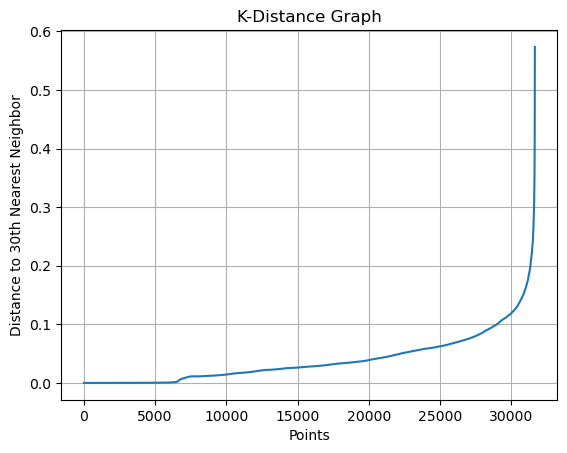

In [23]:
neigh = NearestNeighbors(n_neighbors=20)
neigh.fit(df_behaviour)

distances, _ = neigh.kneighbors(df_behaviour)
distances = np.sort(distances[:, -1])

plt.plot(distances)
plt.xlabel('Points')
plt.ylabel('Distance to 30th Nearest Neighbor')
plt.title('K-Distance Graph')
plt.grid(True) 
plt.show()


### 3.5.2. DBSCAN - optimal number
From the previous graph we are able to conclude that the ideal **`eps`** is around 1 and 2 eps, so we choose 1.5 for this variable.

In [24]:
# # Perform DBSCAN clustering
# dbscan = DBSCAN(eps=2, min_samples=30, n_jobs=4)
# dbscan_labels = dbscan.fit_predict(df_behaviour)

# dbscan_n_clusters = len(np.unique(dbscan_labels))
# print("Number of estimated clusters : %d" % dbscan_n_clusters)

This clustering won't be used nor analysed further because:
- Too computationaly expensive
- The results are not the best (forms 2 clusterings, one of noise and the other one of not noise)
- Its biggest strenght is being used in the removal of outliers.

<a class="anchor" id="gmm">
    
## 3.6. Gaussian Mixture
</a>

### 3.6.1. GMM - Determining number of clusters
For this we will use a plot that determines the optimal number of components (`n_components`) for a Gaussian Mixture Model (GMM) by comparing the Akaike Information Criterion (AIC) and Bayesian Information Criterion (BIC).
  - **X-axis**: Represents the number of components in the GMM, ranging from 1 to 15.  
  - **Y-axis**: Shows the AIC and BIC scores. Lower values on the y-axis indicate better models based on the respective criteria.  

- **AIC (Akaike Information Criterion)**:  
  - Measures the goodness of fit while penalizing for model complexity.  
  - Lower AIC values signify a better balance between model complexity and fit.

- **BIC (Bayesian Information Criterion)**:  
  - Similar to AIC but applies a stronger penalty for complexity, favoring simpler models.  
  - Lower BIC values indicate the preferred model under this criterion.

- **Elbow Point in the Curve**: at **3 components**, because it's where the curve starts to flatten, suggesting that adding more components beyond this range provides diminishing improvements in model fit.

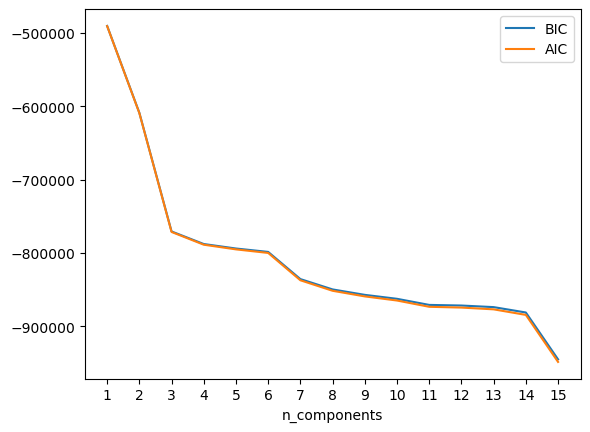

In [25]:
n_components = np.arange(1, 16)
models = [GaussianMixture(n, covariance_type='full', n_init=10, random_state=1).fit(df_behaviour)
          for n in n_components]

bic_values = [m.bic(df_behaviour) for m in models]
aic_values = [m.aic(df_behaviour) for m in models]
plt.plot(n_components, bic_values, label='BIC')
plt.plot(n_components, aic_values, label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')
plt.xticks(n_components)
plt.show()

### 3.6.2 GMM - Optimal number of clusters
As previously seen the optimal number of clusters for this algorithm is 3, this way we will continue with this value.

In [26]:
gmm = GaussianMixture(n_components=3, covariance_type='full', n_init=10, init_params='kmeans', random_state=1)
gmm_labels = gmm.fit_predict(df_behaviour)

In [27]:
#proportion of the data that belongs to each cluster
gmm.weights_

array([0.21627032, 0.22887962, 0.55485006])

In [28]:
df_concat = pd.concat([df_behaviour, pd.Series(gmm_labels, name='gmm_labels', index=df_behaviour.index)], axis=1)
df_grouped = df_concat.groupby('gmm_labels').mean()
df_grouped

,0,1,2,3,4,5
gmm_labels,,,,,,
0,0.025115,0.004655,0.000000,0.015433,0.016063,0.000000
1,0.159101,0.159791,0.728706,0.158703,0.165993,0.266028
2,0.047465,0.034146,0.408670,0.046486,0.050893,0.100164


In [157]:
r2 = get_r2(df_behaviour, gmm_labels)
print(f"R² Score: {r2}")
silhouete = silhouette_score(df_behaviour, gmm_labels)
print(f"Silhouette Score: {silhouete}")
mean = pd.DataFrame({"Silhouette_Score": [silhouete], "R2": [r2]}, index=["Gaussian Mixture_3"])
results_df = pd.concat([results_df, mean], axis=0, ignore_index=False)

R² Score: 0.5262381904970271
Silhouette Score: 0.2068986593782317


## 3.7. Clustering assessment
To measure the different clustering algorithms used, we use the following metrics:
- **R²:** explains how well the clustering algorithm explains the variance in the data. A higher R² value indicates that the clustering model better fits the data, with fewer unexplained variations.
- **Sillhouete Score:** measures how similar each point is to its own cluster compared to other clusters. It ranges from -1 to +1, where a score closer to +1 indicates well-defined clusters, and values closer to -1 suggest poor clustering. A higher silhouette score generally implies better clustering quality.
- **Amount of clusters**: Besides fewer clusters being more able to generalize the data rather than overfit it, it makes the model simpler. As the only options chosen from the previous clusterings were 2 or 3 clusters, this variable has a small weight in the decision of which clustering to use,

This way, we want to choose the clustering algorithm that shows the best balance between the three metrics.
- R²:Weight = 0.35 as this value measures how well the clustering algorithm explains the variance in the data. However, it's not the ebst metric to evaluate the clustering because it always tends to increase with more clusters and it doesn´t account for meaningfulness or separation of the clusters.

- Silhouete score: Weight = 0,55 as it is a better evaluation metric than R² because it measures how well each data point fits into its own cluster relative to other clusters. this way, evaluating if the clustering fits the data and if similar points are together.

- Number of clusters: Weight = 0,1 as the only options chosen from the previous clusterings were 2 or 3 clusters, this variable has a small weight in the decision of which clustering to use.


In [158]:
results = results_df
results["Clusters"] = results.index.str.slice(-1).astype(int)  # Convert the index to float and assign it to 'Clusters'
# Normalize the Clusters column: invert the number of clusters (smaller is better)
results["Clusters_Inverted"] = 1 / results["Clusters"]

# Apply the weighted formula
results["Ranking"] = (results["Silhouette_Score"] * 0.55 + 
                       results["R2"] * 0.35 + 
                       results["Clusters_Inverted"] * 0.1)

# Rank the results based on the new ranking (higher values = better ranks)
results["Rank"] = results["Ranking"].rank(ascending=False, method="min")

# Drop the temporary "Clusters_Inverted" column if not needed
results = results.drop(columns=["Clusters_Inverted", "Ranking" ])

# Display the result
results

results = results.sort_values(by=["Rank"], ascending=True)
results

,Silhouette_Score,R2,Clusters,Rank
KMeans_2,0.545936,0.630808,2,1.0
KMeans_3,0.460286,0.744115,3,2.0
HC_3,0.434698,0.724775,3,3.0
HC_3,0.434698,0.724775,3,3.0
HC_2,0.464714,0.529229,2,5.0
Mean-Shift_3,0.441268,0.201332,3,6.0
Gaussian Mixture_3,0.206899,0.526238,3,7.0
Gaussian Mixture_3,0.206899,0.526238,3,7.0


From this table we conclude that the best clustering algorithm for df_behaviour is **K-Means** with **2 clusters**.     